# Pipeline for locally accessing Inpainting API by stability AI.

## 0. Install Required Libraries

pip install pillow requests ipython

## 1. Import Required Libraries

In [1]:
from io import BytesIO
import json
import os
from PIL import Image
import requests
import time
from IPython.display import display

## 2. Connect to stability API

In [2]:
import getpass
# To get your API key, message me on slack to receive it...
STABILITY_KEY = getpass.getpass('Enter your API Key: ')


## 3. Define Helper Functions

In [3]:
def send_generation_request(host, params):
    headers = {
        "Accept": "image/*",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    # Encode parameters
    files = {}
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image:
        files["image"] = open(image, 'rb')
    if mask:
        files["mask"] = open(mask, 'rb')
    if not files:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    return response

def send_async_generation_request(host, params):
    headers = {
        "Accept": "application/json",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    # Encode parameters
    files = {}
    if "image" in params:
        image = params.pop("image")
        files = {"image": open(image, 'rb')}

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    # Process async response
    response_dict = response.json()
    generation_id = response_dict.get("id")
    if not generation_id:
        raise Exception("Expected 'id' in response")

    # Loop until result or timeout
    timeout = int(os.getenv("WORKER_TIMEOUT", 500))
    start = time.time()
    status_code = 202
    while status_code == 202:
        response = requests.get(
            f"{host}/result/{generation_id}",
            headers={
                **headers,
                "Accept": "image/*"
            },
        )

        if not response.ok:
            raise Exception(f"HTTP {response.status_code}: {response.text}")
        status_code = response.status_code
        time.sleep(10)
        if time.time() - start > timeout:
            raise Exception(f"Timeout after {timeout} seconds")

    return response


## 4. Specify Paths and Prompts

In [8]:
image = "C:/Users/Admin/Desktop/Internship Cultural LLM/Github/Pipeline/ImageSynthPipeline/API_Access/Input_Images/1.PNG"  # Replace with your image path Please do this...
mask = "C:/Users/Admin/Desktop/Internship Cultural LLM/Github/Pipeline/ImageSynthPipeline/API_Access/Input_Masks/Mask.png"  # Replace with your mask image path if any
prompt = "Man eating the food."  # Your prompt
negative_prompt = ""  # Your negative prompt (optional)
seed = 0  # Seed value (0 for random)
output_format = "png"  # Choose from "webp", "jpeg", or "png"

## 5. Perform Inpainting

Sending REST request to https://api.stability.ai/v2beta/stable-image/edit/inpaint...
Saved image edited_1_494207323.png
Original image:


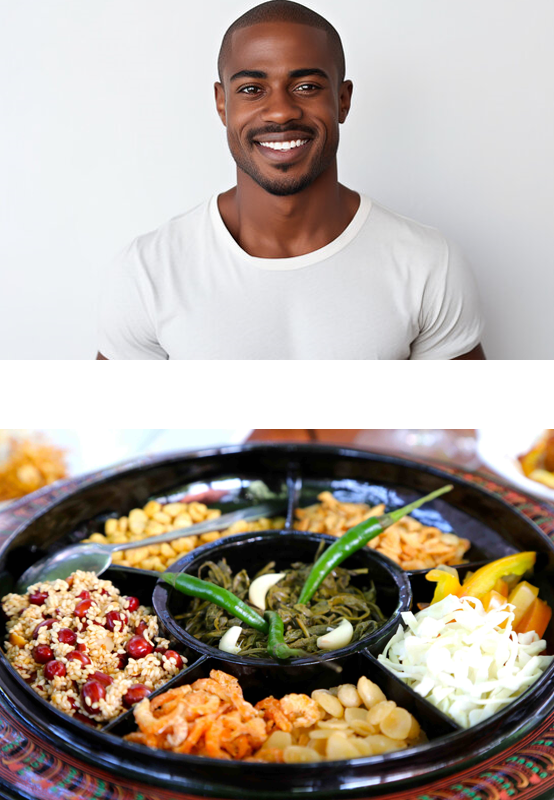

Result image:


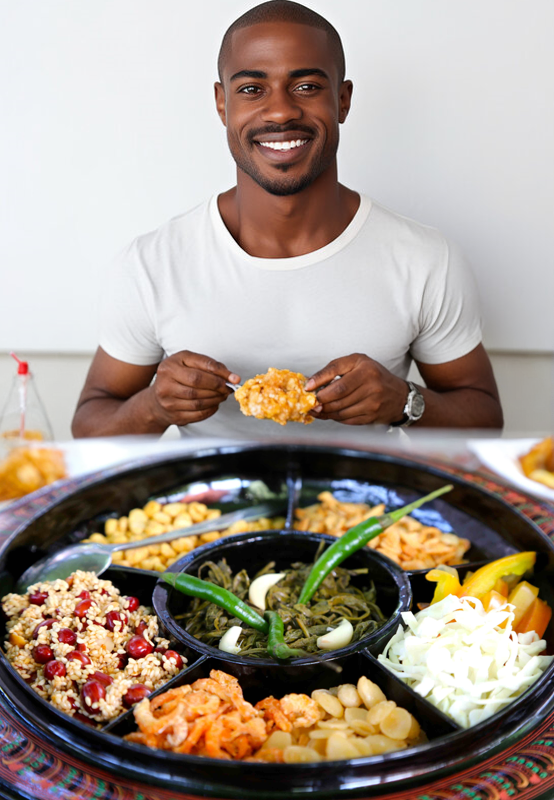

In [9]:
host = "https://api.stability.ai/v2beta/stable-image/edit/inpaint"

params = {
    "image": image,
    "mask": mask,
    "negative_prompt": negative_prompt,
    "seed": seed,
    "mode": "mask",
    "output_format": output_format,
    "prompt": prompt
}

response = send_generation_request(host, params)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
edited = f"edited_{filename}_{seed}.{output_format}"
with open(edited, "wb") as f:
    f.write(output_image)
print(f"Saved image {edited}")

# Display the images
print("Original image:")
display(Image.open(image))
print("Result image:")
display(Image.open(edited))